# Discrete Fourier Transform

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


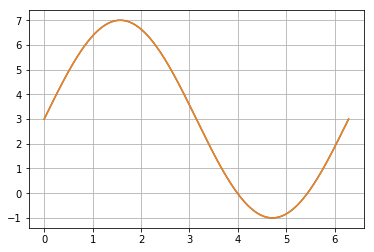

In [2]:
nu = 4096
t = linspace(0, 2*pi, nu)
f = 3 + 4*sin(t)
f2 = np.real(fft.fft([3, 0], nu)) + np.imag(fft.fft([0, -4], nu))
#f2 = np.conj(np.real(fft.ifft([1, 0], nu)) + np.imag(fft.ifft([1, 0], nu)))*nu

plot(t, f)
plot(t, f2)
grid()

In [3]:
nu = 4
t = linspace(0, 2*pi, nu)
F = fft.fft(np.eye(nu))
print(np.round(F, 1))

[[ 1.+0.j  1.+0.j  1.+0.j  1.-0.j]
 [ 1.+0.j  0.-1.j -1.+0.j  0.+1.j]
 [ 1.+0.j -1.+0.j  1.+0.j -1.-0.j]
 [ 1.+0.j  0.+1.j -1.+0.j  0.-1.j]]


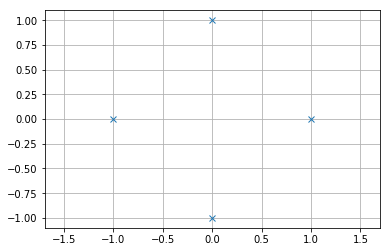

In [4]:
lam = exp(-1j*2*pi/nu)
z = lam**range(nu)
plt.plot(real(z), imag(z), 'x')
np.round(z, 2)
grid()
axis('equal');

In [5]:
def my_ift(x):
    nu = len(x)
    lam = exp(-1j*2*pi/nu)
    F = np.zeros((nu, nu), dtype=complex)
    ak_vect = np.hstack([np.arange(0, nu//2 + 1), -np.arange(nu//2 - (nu%2 == 0), 0, -1)])
    j_vect = np.arange(nu)
    for k in ak_vect:
        for j in j_vect:
            F[j, k] = lam**(k*j)
    return np.conj(F).dot(x)/nu

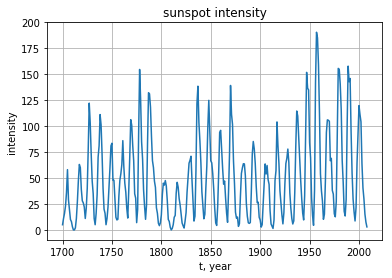

In [6]:
sunspot = np.genfromtxt('./data/sunspots.csv',
              delimiter=',', skip_header=1)
plt.plot(sunspot[:, 0], sunspot[:, 1])
xlabel('t, year');
ylabel('intensity')
title('sunspot intensity')
grid()

Text(0.5, 0, 'freq cycles/year')

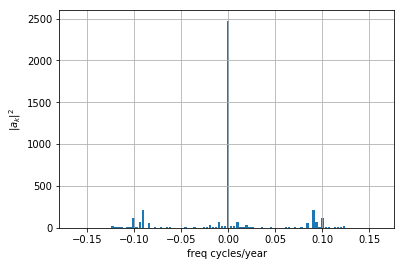

In [7]:
T0 = sunspot[-1, 0] - sunspot[0, 0]
ak = my_ift(sunspot[:, 1])
k = arange(-50, 50)
bar(k/T0, abs(ak[k])**2, width=0.8/T0)
grid()
ylabel('$|a_k|^2$')
xlabel('freq cycles/year')

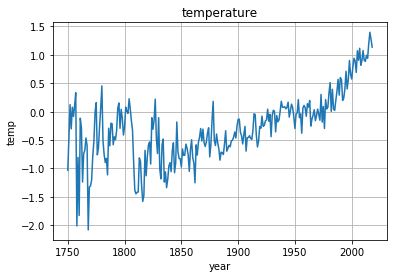

In [8]:
from datetime import datetime
temp = np.loadtxt(
    "./data/global_temp.txt",
    skiprows=22, dtype=float)
plt.plot(temp[:, 0], temp[:, 1])
plt.xlabel('year')
plt.ylabel('temp')
plt.grid()
plt.title('temperature')
temp;

dominant frequency 0.014925373134328358 cycles/year
dominant period 67.0 years/cycle
0.014925373134328358 (0.00851053769140519-0.1303208928383332j)


Text(0.5, 1.0, 'power spectrum')

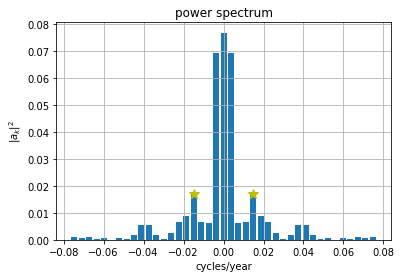

In [9]:
T0 = temp[-1, 0] - temp[0, 0]
nu = len(temp[:, 0])
ak = my_ift(temp[:, 1])
k = np.arange(-20, 21)

a0_skip = 2
k_max = np.argmax(np.abs(ak[a0_skip:nu//2])**2) + a0_skip
freq_max = k_max/T0
print('dominant frequency', freq_max, 'cycles/year')
print('dominant period', 1/freq_max, 'years/cycle')

plt.bar(k/T0, np.abs(ak[k])**2, width=0.8/T0);
plt.ylabel('$|a_k|^2$')
plt.xlabel('cycles/year')
plt.grid()
plt.plot([-freq_max, freq_max],
         np.abs(ak[k_max])**2*np.array([1, 1]), '*', markersize=10, color='y')
print(freq_max, ak[k_max])
plt.title('power spectrum')

Here we want to ignore the $a_0$ and $a_1$ term since they are a constant and the first harmonic which is not very interesting. The $a_1$ power is high, but this is talking aboug the global trend of temperature increase

# Reconstructing Sinusoids from FFT/IFFT

In [10]:
z = np.zeros(4096)
z[1] = 1
np.max(np.abs(fft.ifft([0, 1], 4096) - fft.fft([0, 1], 4096)))

1.000244140625

In [11]:
fft.fft([1, 2, 3], 4096) - np.conj(fft.ifft([1, 2, 3], 4096))*4096

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

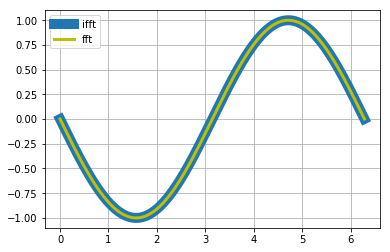

In [12]:
nu = 4096
t = np.linspace(0, 2*pi, nu)

plot(t, nu*imag(fft.ifft([0, -1], nu)), linewidth=10, label='ifft');
plot(t, imag(fft.fft([0, 1], nu)), linewidth=3, color='y', label='fft');
plt.legend()
plt.grid()

# Nyquist Sampling Theorem/ Aliasing

initial sample time: 0.1 seconds
sampling interval: 6.9 seconds


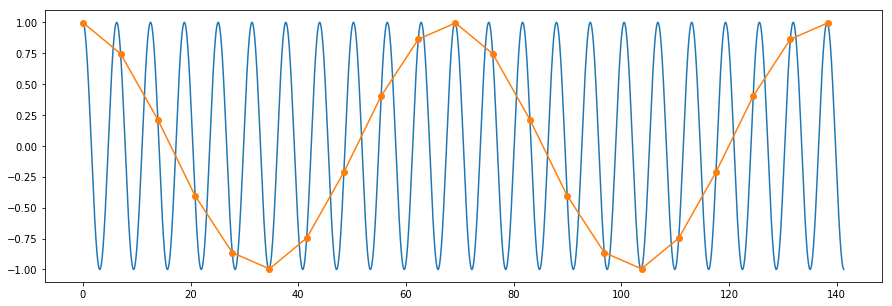

In [13]:
t = arange(0, 45*pi, pi/100)
T = 2*pi
dt = 1.1*T
t0 = 0.1

ts = arange(t0, 45*pi, dt)

figure(figsize=(15, 5))
plot(t, cos(t))
plot(ts, cos(ts), 'o-')

print('initial sample time: {:0.2g} seconds'.format(t0))
print('sampling interval: {:0.2g} seconds'.format(dt))

# Image Processing 

In [14]:
def add_noise(data, n):
    data2 = np.copy(data)
    for i in range(n):
        j = np.random.randint(0, data2.shape[0])
        k = np.random.randint(0, data2.shape[1])
        data2[j, k] = int(255*np.random.rand())
    return data2

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def analyze_image(file, noise=0, cx=30, cy=30):
    img = cv2.imread(file, 0)  # read in image as greyscale, 0 means greyscale
    img = add_noise(img, noise)   # add noise to image

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # move a0 to the center of the image to make filtering easier

    fshift_orig = np.copy(fshift)  # make a copy so we can modify fshift
    mag_spectrum = 20*np.log(np.abs(fshift_orig))  # magnitude in dB

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2
    
    # gaussian kernel
    colrow = np.array(np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0])))
    z = 1 - np.array(np.exp(-((colrow[1] - crow)**2/(2*cy**2) + (colrow[0] - ccol)**2/(2*cx**2))))   
    
    fshift_high = np.copy(fshift)
    
    fshift_high = np.multiply(fshift_high, z)  # high pass filter using gaussian
    #fshift_high[crow-cy:crow+cy, ccol-cx:ccol+cx] = 0  # high pass filter, set small ak's to zero

    mag_spectrum_high = 20*np.log(np.abs(fshift_high) + 1e-20)
    f_ishift = np.fft.ifftshift(fshift_high)  # shift back s o in right form
    img_high = np.fft.ifft2(f_ishift)

    img_high = np.real(img_high)  # remove numerical complex numbers

    img_low = img - img_high
    mag_spectrum_low = 20*np.log(np.abs(fshift_orig - fshift_high) + 1e-20)
    
    vmin = 0
    vmax = 255
    
    print(np.min(img_low), np.max(img_low))
    print(np.min(img_high), np.max(img_high))

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image')
    plt.axis('tight')

    plt.subplot(122),plt.imshow(mag_spectrum, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')
    plt.show()

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img_high, cmap = 'gray', vmin=-vmax, vmax=vmax)
    plt.title('Image after High Pass Filter')
    plt.axis('tight')

    plt.subplot(122), plt.imshow(mag_spectrum_high, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img_low, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.title('Image after Low Pass Filter')
    plt.axis('tight')

    plt.subplot(122), plt.imshow(mag_spectrum_low, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')


51.44591820445494 195.74944300446376
-178.66258819087045 181.95260463204872


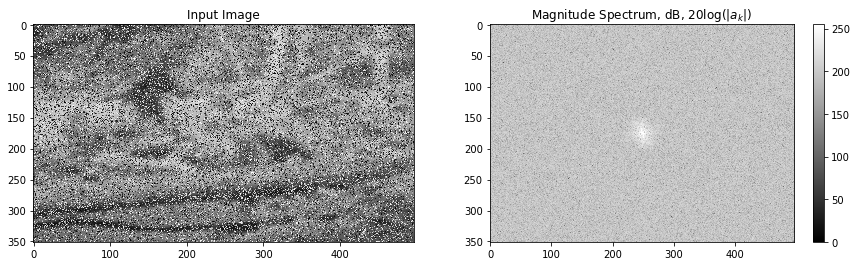

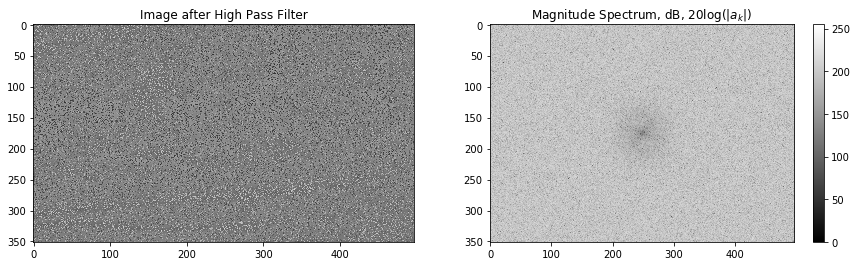

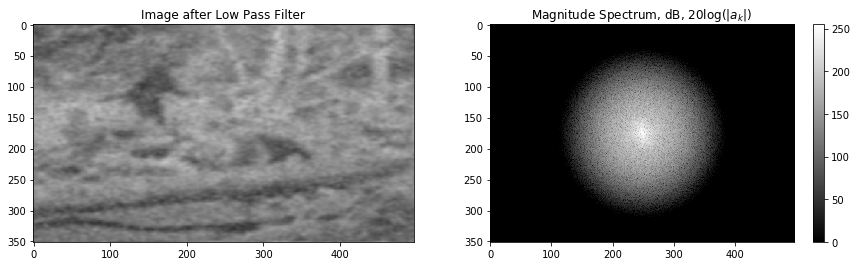

In [16]:
analyze_image('./data/bigfoot.png', noise=100000, cx=30, cy=30)

-0.00021607081901464653 174.08057129632277
-142.2714080631547 163.6214982195882


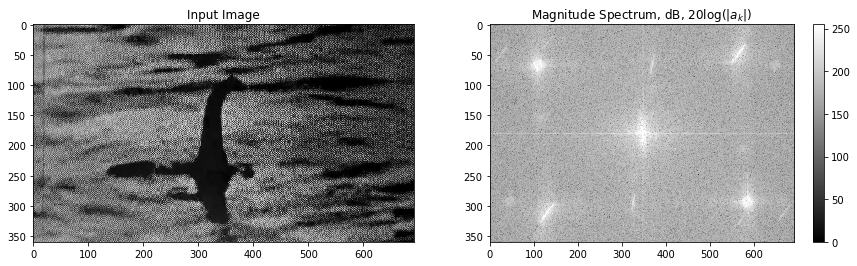

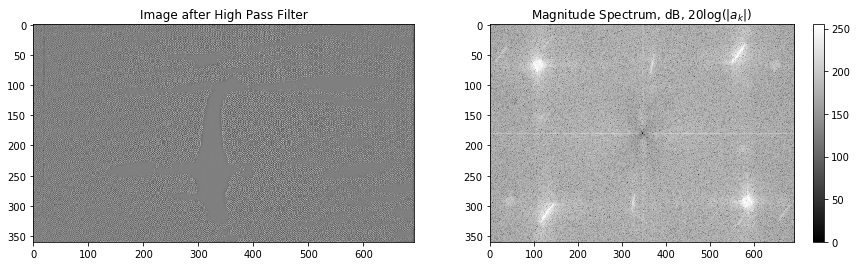

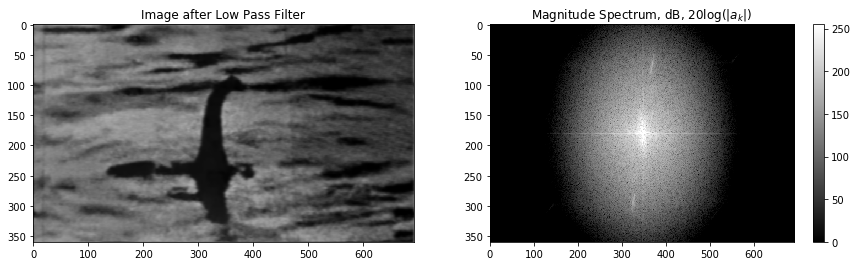

In [17]:
analyze_image('./data/nessy.jpg', noise=0, cx=50, cy=50)

66.8865988453693 197.5550051528936
-193.49322698133375 187.59790402644248


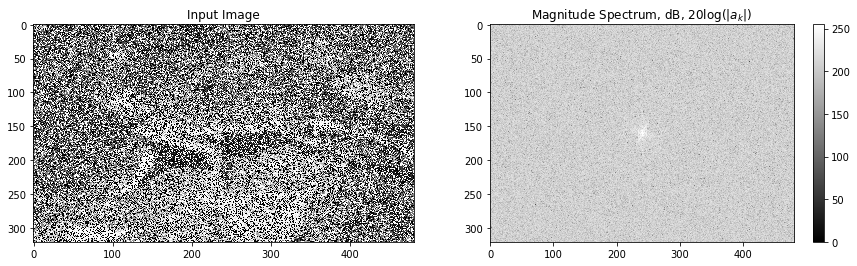

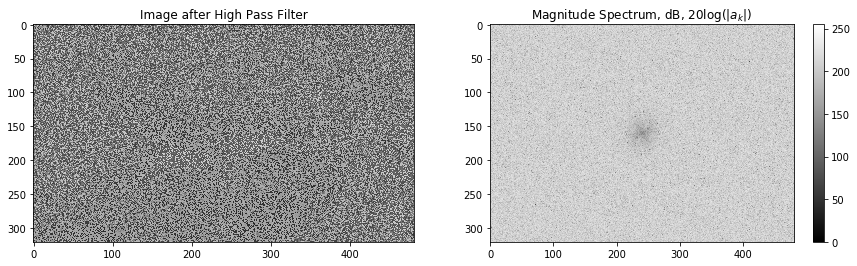

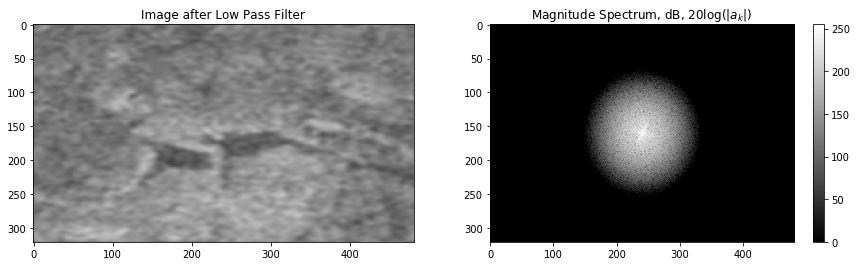

In [18]:
analyze_image('./data/lizard_noisy.png', noise=0, cx=20, cy=20)